In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

np.random.seed(74207281-1)

### 0. Preprocessing

In [2]:
mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

# mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = mini_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

CPU times: user 4.16 s, sys: 815 ms, total: 4.98 s
Wall time: 4.99 s


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

CPU times: user 93.7 ms, sys: 35 µs, total: 93.7 ms
Wall time: 93.3 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((2,2))))

Lets visualize the transformations:

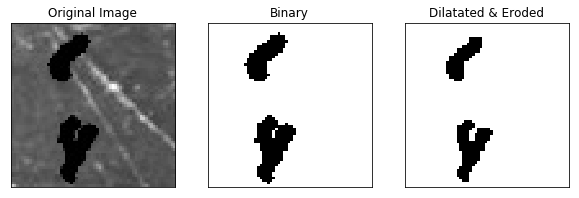

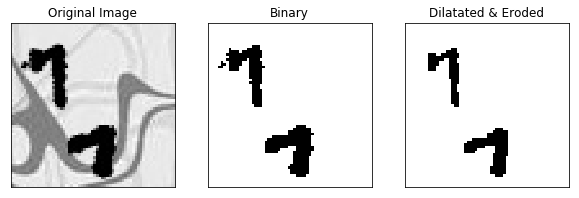

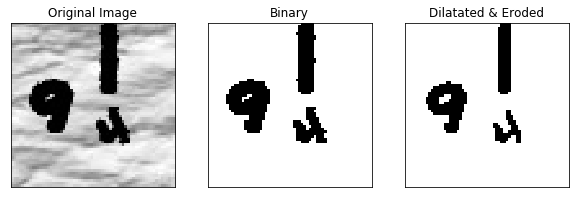

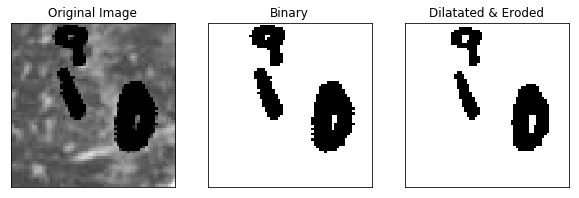

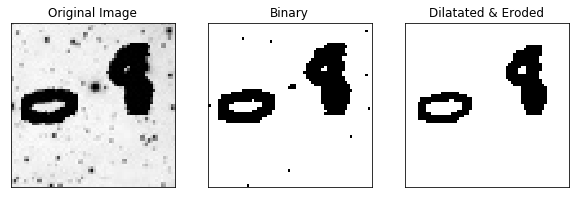

In [6]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original Image', 'Binary', 'Dilatated & Eroded']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5]]
plot_images(images, titles)

Finally we will blur in order to smooth any edges __(TEST IF THIS IS ACTUALLY USEFUL)__

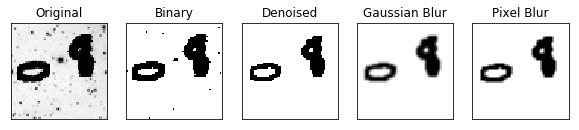

In [7]:
blurred_imgs = []
for denoised_img in denoised_imgs:
    blurred_imgs.append(cv2.blur(denoised_img,(2,2)))

random_idx = 4
blur = cv2.blur(denoised_imgs[random_idx],(2,2))
gaussian_blur = cv2.GaussianBlur(denoised_imgs[random_idx],(3,3),0)    
plt.subplot(151),plt.imshow(imgs[random_idx],'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(152),plt.imshow(bin_imgs[random_idx],'gray'),plt.title('Binary')
plt.xticks([]), plt.yticks([])
plt.subplot(153),plt.imshow(denoised_imgs[random_idx],'gray'),plt.title('Denoised')
plt.xticks([]), plt.yticks([])
plt.subplot(154),plt.imshow(gaussian_blur,'gray'),plt.title('Gaussian Blur')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(blur,'gray'),plt.title('Pixel Blur')
plt.xticks([]), plt.yticks([])
plt.show()

### 1. Linear Learners

In [8]:
# hyperparameter permutations
SEED = 42    # random state seed for consistent results
FOLDS = 3    # number of folds for K-fold cross validation
DUAL = [False, True] # WHEN n_samples > n_features DUAL=FALSE
LOSSES = ['squared_hinge','hinge']
PENALTIES = ['l1','l2']
SOLVERS = ['lbfgs'] # 'newton-cg','sag','saga',
# error_coefs = np.logspace(-0.01, 2, 15)
# FOUND OUT A SMALLER RANGE OF GOOD VALUES
error_coefs = np.linspace(20,80, 10)

KFOLD = KFold(n_splits=FOLDS, random_state=SEED)

clean_X = [img.flatten() for img in denoised_imgs]
clean_X = list(map(lambda x: x/255, clean_X))
mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_test_split(clean_X, mini_y, 
                                                                        test_size=0.3,
                                                                        random_state=SEED)

#### Helper methods
Methods to generate all possible permutations of HyperParameters 
for LinearSVMs and Logistic Regressor:

In [ ]:
def get_svm_hp_permutations():
    clfs = []
    for d in DUAL:
        for l in LOSSES:
            for p in PENALTIES:
                # ignore unvalid combinations
                if not d and p == 'l2': continue
                if p == 'l1' and l == 'hinge': continue
                if d and p == 'l1' and l == 'squared_hinge': continue

                for c in error_coefs:
                    clfs.append(LinearSVC(C=c,dual=d,loss=l,penalty=p))
    
    return clfs

def get_logreg_hp_permutations():
    clfs = []
#     for d in DUAL:
    for p in PENALTIES:
        for s in SOLVERS:
            # ignore unvalid combinations
#             if not d and p == 'l2': continue
            if s != 'saga' and p == 'l1': continue

            for c in error_coefs:
                clfs.append(LogisticRegression(C=c,penalty=p,solver=s,n_jobs=8))
    
    return clfs

#### Base and dummy clf performances for reference

In [ ]:
# dummy clf performance
random_clf = DummyClassifier(random_state=42)
result = cross_val_score(random_clf, mini_X_train, mini_y_train, cv=KFOLD, scoring='f1_micro')
print('Random clf performance: {:.4f}'.format(result.mean()))

# Base performance (default HP)
result = cross_val_score(LinearSVC(), mini_X_train, mini_y_train, cv=KFOLD, scoring='f1_micro')
print('LinearSVM base performance: {:.4f}'.format(result.mean()))

result = cross_val_score(LogisticRegression(), mini_X_train, mini_y_train, cv=KFOLD, scoring='f1_micro')
print('LogReg base performance: {:.4f}'.format(result.mean()))

#### Perform Model Selection for LinearSM

In [ ]:
scores = []
# create preprocessing pipeline
for specific_svm_permutation in get_svm_hp_permutations():
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('clf', specific_svm_permutation))
    model = Pipeline(estimators)
    result = cross_val_score(model, mini_X_train, mini_y_train, cv=KFOLD, scoring='f1_micro')

    scores.append((specific_svm_permutation, result.mean()))
    
best_svm, max_train = max(scores,key=itemgetter(1)) 
print('Best SVM: \n{}'.format(best_svm))
print('TRAIN SCORE: {:.4f}'.format(max_train))

#### Perform Model Selection for LogisticRegression

In [23]:
scores = []
# create preprocessing pipeline
for specific_logreg_permutation in get_logreg_hp_permutations():
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('clf', specific_logreg_permutation))
    model = Pipeline(estimators)
    result = cross_val_score(model, mini_X_train, mini_y_train, cv=KFOLD, scoring='f1_micro')

    scores.append((specific_logreg_permutation, result.mean()))
    
best_svm, max_train = max(scores,key=itemgetter(1)) 

print('Best SVM: \n{}'.format(best_svm))
print('TRAIN SCORE: {:.4f}'.format(max_train))

NameError: name 'get_logreg_hp_permutations' is not defined

# Neural Network

In [24]:
from neuralnet import *
one_hot_encode = lambda x: np.eye(10)[x]
one_hot_decode = lambda x: np.argmax(x)
y_train = np.array(list(map(lambda x: one_hot_encode(int(x)), mini_y_train)))
y_test = np.array(list(map(lambda x: one_hot_encode(int(x)), mini_y_test)))
epochs = 45

In [31]:
%%time
net = NeuralNetBuilder() \
        .input_layer(64 * 64) \
        .add_layer("sigmoid", 30) \
        .output_layer(10) \
        .build()
        
errors = net.fit(np.array(mini_X_train), y_train, epochs=epochs, gamma=0.00005, debug=True)


1. Error: 82854.1113798
2. Error: 80783.9153206
3. Error: 80724.1589169
4. Error: 80693.8914694
5. Error: 80677.5716914
6. Error: 80666.6463385
7. Error: 80658.108764
8. Error: 80650.9270401
9. Error: 80644.9089425
10. Error: 80639.6146832
11. Error: 80634.5104465
12. Error: 80628.9353478
13. Error: 80623.0536068
14. Error: 80617.9287937
15. Error: 80613.3965738
16. Error: 80609.0974336
17. Error: 80604.9130812
18. Error: 80600.8043287
19. Error: 80596.7549839
20. Error: 80592.7548815
21. Error: 80588.7950811
22. Error: 80584.8839568
23. Error: 80581.0870809
24. Error: 80576.719901
25. Error: 80571.7281311
26. Error: 80566.4957742
27. Error: 80560.6056961
28. Error: 80555.2755886
29. Error: 80550.1139665
30. Error: 80544.9385093
31. Error: 80539.7906831
32. Error: 80534.6865232
33. Error: 80529.635036
34. Error: 80524.6448343
35. Error: 80519.7220409
36. Error: 80514.8677023
37. Error: 80510.0766308
38. Error: 80505.3386845
39. Error: 80500.6428078
40. Error: 80495.9806132
41. Error: 8

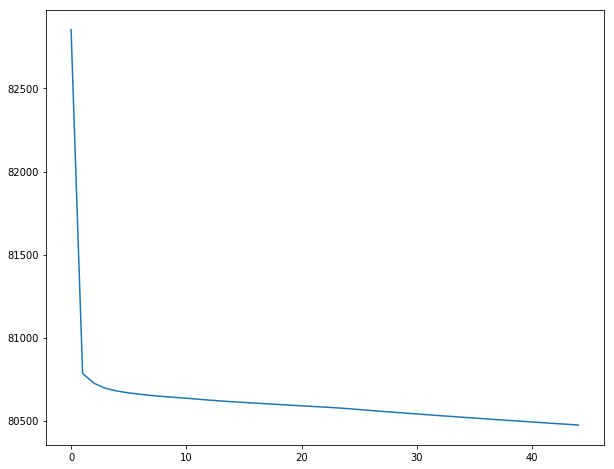

In [32]:
plt.plot(list(range(epochs)), errors)

In [33]:
dataset = list(zip(np.array(mini_X_test), y_test))
correct = 0
predictions = []
for (x, y) in dataset:
    predictions.append(net.predict(x))
    if net.predict(x) == one_hot_decode(y):
        correct += 1
print("Accuracy is " + str(100.0 * float(correct) / len(y_test)) + "%")
print(predictions)
print(net.layers[-1].vals)
print(net.layers[-1].weights)
print(net.layers[-1].b)
print(np.sum(net.layers[-1].vals))

Accuracy is 12.173333333333334%
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 6, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 7, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0

In [15]:
net.predict(mini_X_train[12])

1

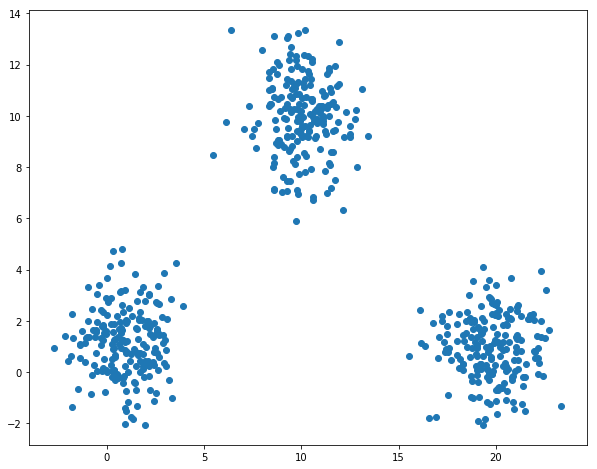

In [35]:
X = []
y = []
u1 = np.array([1, 1])
u2 = np.array([10,10])
u3 = np.array([20,1])
cov = np.array([[2,0],[0,2]])
for i in range(200):
    X.append(np.random.multivariate_normal(u1,cov))
    y.append(0)
    X.append(np.random.multivariate_normal(u2,cov))
    y.append(1)
    X.append(np.random.multivariate_normal(u3,cov))
    y.append(2)
    
X0 = [x[0] for x in X]
X1 = [x[1] for x in X]

plt.scatter(X0, X1)
plt.show()

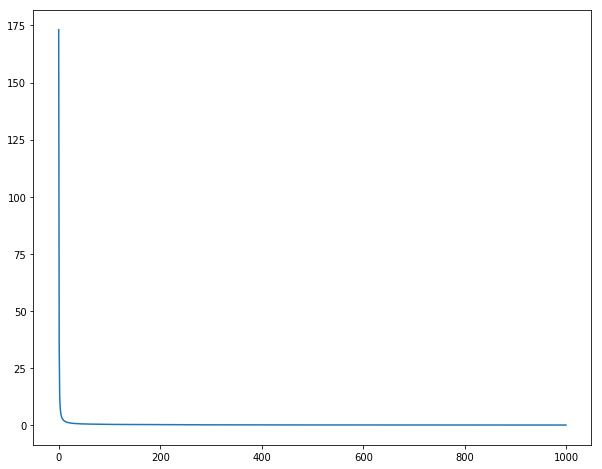

Accuracy: 100.0%
[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]


In [47]:
enc = lambda x: np.eye(3)[x]
dec = lambda x: np.argmax(x)

epochs = 1000

X_train = np.array(X[:300])
y_train = np.array(list(map(enc, y[:300])))

n = NeuralNetBuilder().input_layer(2).add_layer("sigmoid", 6).output_layer(3).build()
errors = n.fit(X_train, y_train, epochs=epochs, gamma=0.1)
plt.plot(list(range(epochs)), errors)
plt.show()
X_test = X[300:]
y_test = y[300:]
correct = 0
dataset = list(zip(X_test, y_test))
predictions = []
for (a,b) in dataset:
    predictions.append(n.predict(a))
    if n.predict(a) == b:
        correct += 1
print("Accuracy: " + str(100.0 * float(correct) / 300) + "%")
print(predictions)